# Number Plate Detection with EfficientDet

### Download the dataset

The dataset: [the CCPD Repository](https://github.com/detectRecog/CCPD).

In [ ]:
import os
import sys

%cd /content
if not os.path.exists("CCPD2019"):
    %pip install gdown
    import gdown
    url = "https://drive.google.com/uc?id=1rdEsCUcIUaYOVRkx5IMTRNA7PcGMmSgc"
    dsetname = "CCPD2019.tar.xz"
    gdown.download(url, dsetname, quiet=False)
    
    !tar xf {dsetname}
    !rm {dsetname}
    # due to the storage limitation on Colab, we remove the testing set
    !rm -rf CCPD2019/ccpd_blur CCPD2019/ccpd_challenge CCPD2019/ccpd_db CCPD2019/ccpd_fn CCPD2019/ccpd_np CCPD2019/ccpd_rotate CCPD2019/ccpd_tilt CCPD2019/ccpd_weather

/content


### Downloading the EfficientDet

In [ ]:
if not os.path.isdir("automl"):
    # clone the repository
    !git clone --depth 1 https://github.com/google/automl
        
    # checkout to the latest commit that we used when we're creating this notebook
    %cd automl
    !git checkout 1ec78d22aa9f8b7d33b9cf3a177e05dcc6b4a093
    
    # change the working directory
    %cd efficientdet
    
    # install required packages
    # if it fails to install pycocotools, please manually remove pycocotools from requirements.txt and run again
    %pip install -r requirements.txt
    %pip install -U "git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI"

PROJ_DIR = os.path.join("..", "..")

automl	CCPD2019  configs  models  results  sample_data  tfrecords  tmp


In [ ]:
MODEL = "efficientdet-d1"
if not os.path.exists(f"{MODEL}.tar.gz"):
    !curl -O https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco2/{MODEL}.tar.gz
    !tar xvzf {MODEL}.tar.gz

## Preprocessing 

### Preprocessing parameters

In [ ]:
DATASET_DIR = os.path.join(PROJ_DIR, "CCPD2019")
TFRECORD_DIR = os.path.join(PROJ_DIR, "tfrecords")

TRAIN_SET_FILE = os.path.join(DATASET_DIR, "splits", "train.txt")
VAL_SET_FILE = os.path.join(DATASET_DIR, "splits", "val.txt")
TEST_SET_FILE = os.path.join(DATASET_DIR, "splits", "test.txt")

SAMPLES_PER_FILE = 10000   # we only construct a subset, in total there are 100,000 samples in each set

LP_CLASS = 1   # class id for the license plate

In [ ]:
import re
import hashlib

import PIL.Image
import tensorflow as tf
from tensorflow.compat.v1.python_io import tf_record_iterator


def filename_to_annotation(filename):
    """
    Annotations are embedded in file name.

    A sample image name is "025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg". Each name can be splited into seven fields. Those fields are explained as follows.

        Area: Area ratio of license plate area to the entire picture area.

        Tilt degree: Horizontal tilt degree and vertical tilt degree.

        Bounding box coordinates: The coordinates of the left-up and the right-bottom vertices.

        Four vertices locations: The exact (x, y) coordinates of the four vertices of LP in the whole image. These coordinates start from the right-bottom vertex.

        License plate number: Each image in CCPD has only one LP. Each LP number is comprised of a Chinese character, a letter, and five letters or numbers. A valid Chinese license plate consists of seven characters: province (1 character), alphabets (1 character), alphabets+digits (5 characters). "0_0_22_27_27_33_16" is the index of each character. These three arrays are defined as follows. The last character of each array is letter O rather than a digit 0. We use O as a sign of "no character" because there is no O in Chinese license plate characters.

        Brightness: The brightness of the license plate region.

        Blurriness: The Blurriness of the license plate region.
    """

    m = re.match(
        r'^'
        r'([0-9]+)-'
        r'([0-9]+)_([0-9]+)-'
        r'([0-9]+)&([0-9]+)_([0-9]+)&([0-9]+)-'
        r'([0-9]+)&([0-9]+)_([0-9]+)&([0-9]+)_([0-9]+)&([0-9]+)_([0-9]+)&([0-9]+)-'
        r'([0-9_]+)-'
        r'([0-9]+)-'
        r'([0-9]+)'
        r'.jpg$'
        , filename
    )

    if m:
        m = m.groups()
        anno = {
            "area_ratio": int(m[0]),
            "tilt_h": int(m[1]),
            "tile_v": int(m[2]),
            "bbox": {
                "left": int(m[3]),
                "top": int(m[4]),
                "right": int(m[5]),
                "bottom": int(m[6])
            },
            "lp": str(m[15]),
            "brightness": int(m[16]),
            "blurriness": int(m[17])
        }
        assert anno["bbox"]["left"] < anno["bbox"]["right"]
        assert anno["bbox"]["top"] < anno["bbox"]["bottom"]
    else:
        raise ValueError("the filename cannot be resolved")

    return anno


def create_example(id, filepath, annotation):
    img_raw = open(filepath, "rb").read()
    key = hashlib.sha256(img_raw).hexdigest()
    filename = os.path.basename(filepath)
    width, height = PIL.Image.open(filepath).size

    example = tf.train.Example(features=tf.train.Features(feature={
        "image/height": tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        "image/width": tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        "image/filename": tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode("utf-8")])),
        "image/source_id": tf.train.Feature(bytes_list=tf.train.BytesList(value=[str(id).encode("utf-8")])),
        "image/key/sha256": tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode("utf-8")])),
        "image/encoded": tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        "image/format": tf.train.Feature(bytes_list=tf.train.BytesList(value=["jpg".encode("utf8")])),
        "image/object/bbox/xmin": tf.train.Feature(float_list=tf.train.FloatList(value=[annotation["bbox"]["left"] / width])),
        "image/object/bbox/xmax": tf.train.Feature(float_list=tf.train.FloatList(value=[annotation["bbox"]["right"] / width])),
        "image/object/bbox/ymin": tf.train.Feature(float_list=tf.train.FloatList(value=[annotation["bbox"]["top"] / height])),
        "image/object/bbox/ymax": tf.train.Feature(float_list=tf.train.FloatList(value=[annotation["bbox"]["bottom"] / height])),
        "image/object/class/text": tf.train.Feature(bytes_list=tf.train.BytesList(value=["license_plate".encode("utf-8")])),
        "image/object/class/label": tf.train.Feature(int64_list=tf.train.Int64List(value=[LP_CLASS])),
        "image/object/difficult": tf.train.Feature(int64_list=tf.train.Int64List(value=[0])),
        "image/object/truncated": tf.train.Feature(int64_list=tf.train.Int64List(value=[0])),
        "image/object/view": tf.train.Feature(bytes_list=tf.train.BytesList(value=["Unspecified".encode("utf-8")])),
    }))
    return example


def create_tfrecord(dataset_path, output_path, samples_per_file):
    print(f"creating {dataset_path} at {output_path}")

    # create the output directory if not exist
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # read the dataset
    with open(dataset_path, "r") as fread:
        lines = fread.read().splitlines()

    # write examples into tfrecord
    fid = 0
    partition_path = output_path + f"-{fid:02d}"
    tfwriter = tf.io.TFRecordWriter(partition_path)
    for i, subpath in enumerate(lines):
        if (i + 1) % samples_per_file == 0:
            fid += 1
            partition_path = output_path + f"-{fid:02d}"
            tfwriter.close()
            tfwriter = tf.io.TFRecordWriter(partition_path)

        filepath = os.path.join(DATASET_DIR, subpath)
        filename = os.path.basename(filepath)
        annotation = filename_to_annotation(filename)
        example = create_example(i + 1, filepath, annotation)
        tfwriter.write(example.SerializeToString())
    tfwriter.close()

In [ ]:
create_tfrecord(TRAIN_SET_FILE, os.path.join(TFRECORD_DIR, "train.tfrecord"), SAMPLES_PER_FILE)
create_tfrecord(VAL_SET_FILE, os.path.join(TFRECORD_DIR, "val.tfrecord"), SAMPLES_PER_FILE)
# due to the storage limitation on Colab, we skip the testing set
#create_tfrecord(TEST_SET_FILE, os.path.join(TFRECORD_DIR, "test.tfrecord"), SAMPLES_PER_FILE)

creating ../../CCPD2019/splits/train.txt at ../../tfrecords/train.tfrecord
creating ../../CCPD2019/splits/val.txt at ../../tfrecords/val.tfrecord


## Model training

### Create the config YAML file

In [ ]:
CONFIG_DIR = os.path.join(PROJ_DIR, "configs")
CONFIG_FILE = os.path.join(CONFIG_DIR, "default.yaml")
if not os.path.exists(CONFIG_DIR):
    os.mkdir(CONFIG_DIR)

config_text = \
"""image_size: 1024x1024
num_classes: 1
label_map: {1: license_plate}
input_rand_hflip: true
jitter_min: 0.8
jitter_max: 1.2
"""

with open(CONFIG_FILE, "w") as fwrite:
    fwrite.write(config_text)

### Training parameters

In [ ]:
CKPT = MODEL

TRAIN_SET = os.path.join(TFRECORD_DIR, "train.tfrecord-*")
VAL_SET = os.path.join(TFRECORD_DIR, "val.tfrecord-*")
MODEL_DIR_TMP = os.path.join(PROJ_DIR, "tmp", f"{MODEL}-finetune")
TRAIN_NUM_EXAMPLES = 5000
EVAL_NUM_EXAMPLES = 5000
EPOCHS = 1
BATCH_SIZE = 2

### Remove the previous checkpoint (if exists) before restarting the training

In [ ]:
if os.path.exists(MODEL_DIR_TMP):
    !rm -rf {MODEL_DIR_TMP}

### Training

In [ ]:
!python -m main \
    --mode=train_and_eval \
    --training_file_pattern={TRAIN_SET} \
    --validation_file_pattern={VAL_SET} \
    --model_name={MODEL} \
    --model_dir={MODEL_DIR_TMP} \
    --ckpt={CKPT} \
    --train_batch_size={BATCH_SIZE} \
    --eval_batch_size={BATCH_SIZE} \
    --num_epochs={EPOCHS} \
    --num_examples_per_epoch={TRAIN_NUM_EXAMPLES} \
    --eval_samples={EVAL_NUM_EXAMPLES} \
    --hparams={CONFIG_FILE}

2020-10-18 11:00:37.127251: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
I1018 11:00:40.905839 140485716793216 main.py:228] {'name': 'efficientdet-d1', 'act_type': 'swish', 'image_size': (1024, 1024), 'target_size': None, 'input_rand_hflip': True, 'jitter_min': 0.8, 'jitter_max': 1.2, 'autoaugment_policy': None, 'use_augmix': False, 'grid_mask': False, 'augmix_params': [3, -1, 1], 'sample_image': None, 'num_classes': 1, 'seg_num_classes': 3, 'heads': ['object_detection'], 'skip_crowd_during_training': True, 'label_map': {1: 'license_plate'}, 'max_instances_per_image': 100, 'regenerate_source_id': False, 'min_level': 3, 'max_level': 7, 'num_scales': 3, 'aspect_ratios': [1.0, 2.0, 0.5], 'anchor_scale': 4.0, 'is_training_bn': True, 'momentum': 0.9, 'optimizer': 'sgd', 'learning_rate': 0.08, 'lr_warmup_init': 0.008, 'lr_warmup_epoch': 1.0, 'first_lr_drop_epoch': 200.0, 'second_lr_drop_epoch': 250.0, 'poly_lr_power': 0

## Model inference

### Export the model (from checkpoint to saved model format)

In [ ]:
MODEL_DIR_EXPORT = os.path.join(PROJ_DIR, "models", f"{MODEL}-finetune")

MIN_SCORE_THRESHOLD = 0.1

!python -m model_inspect \
    --runmode=saved_model \
    --model_name={MODEL} \
    --ckpt_path={MODEL_DIR_TMP} \
    --saved_model_dir={MODEL_DIR_EXPORT} \
    --min_score_thresh={MIN_SCORE_THRESHOLD} \
    --hparams={CONFIG_FILE}

2020-10-18 11:58:10.729394: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-18 11:58:12.596195: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200000000 Hz
2020-10-18 11:58:12.596526: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2ca6bc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-10-18 11:58:12.596555: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-10-18 11:58:12.598996: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-18 11:58:12.723759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-18 11:58:12.724449: I tensorflow/compiler/xla/servic

### Run inference

In [ ]:
TEST_IMAGE_DIR = os.path.join(DATASET_DIR, "ccpd_base")
TEST_IMAGE_FILES = os.path.join(TEST_IMAGE_DIR, "*.jpg")
#TEST_IMAGE_FILES = os.path.join(TEST_IMAGE_DIR, "09-1_13-81&477_603&621-578&604_81&621_106&494_603&477-0_0_24_31_3_27_30-102-134.jpg")

RESULT_DIR = os.path.join(PROJ_DIR, "results")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)

# we can set a higher threshold here
# however, the results are already filtered with the previous threshold during the model exporting
MIN_SCORE_THRESHOLD = 0.5

!python -m model_inspect \
    --runmode=saved_model_infer \
    --saved_model_dir={MODEL_DIR_EXPORT} \
    --model_name={MODEL} \
    --input_image={TEST_IMAGE_FILES} \
    --output_image_dir={RESULT_DIR} \
    --min_score_thresh={MIN_SCORE_THRESHOLD} \
    --hparams={CONFIG_FILE}

2020-10-18 12:05:28.597130: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-18 12:05:30.342245: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200000000 Hz
2020-10-18 12:05:30.342453: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3092d80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-10-18 12:05:30.342486: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-10-18 12:05:30.344545: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-18 12:05:30.454218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-18 12:05:30.454890: I tensorflow/compiler/xla/servic

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



52&657_341&651_335&581_546&587-0_7_20_30_26_31_21-130-64.jpg', '../../CCPD2019/ccpd_base/0103807471264-90_90-373&578_557&650-553&646_371&643_373&582_555&585-0_0_22_16_27_31_33-81-35.jpg', '../../CCPD2019/ccpd_base/00903975095786-91_88-214&426_384&494-391&510_210&499_214&433_395&444-0_0_22_30_29_27_7-83-15.jpg', '../../CCPD2019/ccpd_base/0349197796935-88_91-217&435_531&537-534&530_222&546_231&449_543&433-0_0_5_29_33_27_23-114-28.jpg', '../../CCPD2019/ccpd_base/0216570881226-90_85-195&496_480&591-485&589_216&578_191&498_460&509-0_0_5_9_28_26_24-151-59.jpg', '../../CCPD2019/ccpd_base/0117397030652-90_85-304&484_496&559-504&554_312&553_314&486_506&487-0_0_2_29_31_26_22-110-38.jpg', '../../CCPD2019/ccpd_base/0222880747126-90_91-197&397_484&490-473&480_207&484_211&404_477&400-0_0_18_18_24_33_32-46-58.jpg', '../../CCPD2019/ccpd_base/0199137931034-90_86-200&448_475&519-478&521_196&521_190&443_472&443-0_0_24_28_18_24_32-127-73.jpg', '../../CCPD2019/ccpd_base/0377370689655-88_89-143&359_476&482-

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




2020-10-18 12:05:43.248295: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2020-10-18 12:05:44.396874: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
writing file to ../../results/0.jpg
writing file to ../../results/1.jpg
writing file to ../../results/2.jpg
writing file to ../../results/3.jpg
writing file to ../../results/4.jpg
writing file to ../../results/5.jpg
writing file to ../../results/6.jpg
writing file to ../../results/7.jpg
writing file to ../../results/8.jpg
writing file to ../../results/9.jpg
writing file to ../../results/10.jpg
writing file to ../../results/11.jpg
writing file to ../../results/12.jpg
writing file to ../../results/13.jpg
writing file to ../../results/14.jpg
writing file to ../../results/15.jpg
writing file to ../../results/16.jpg
writing file to ../../results/17.jpg
writing file to ../../results/18.jpg
writing file to ../.

### Visualize the results

../../results/0.jpg


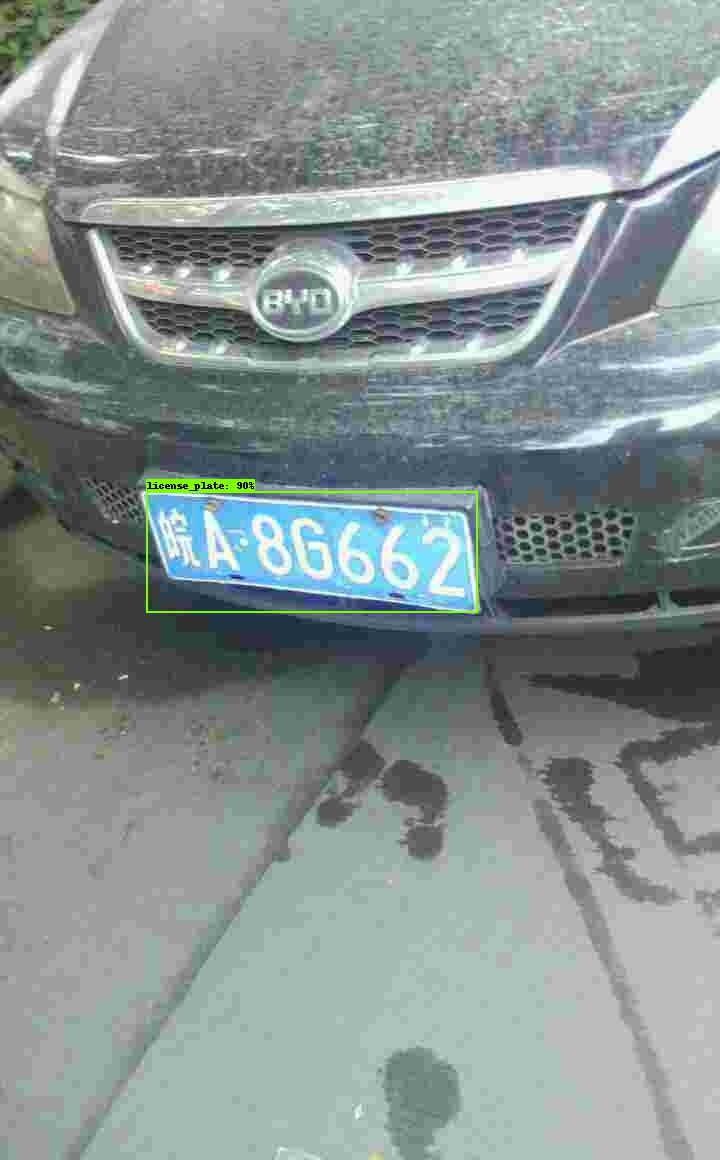

../../results/1.jpg


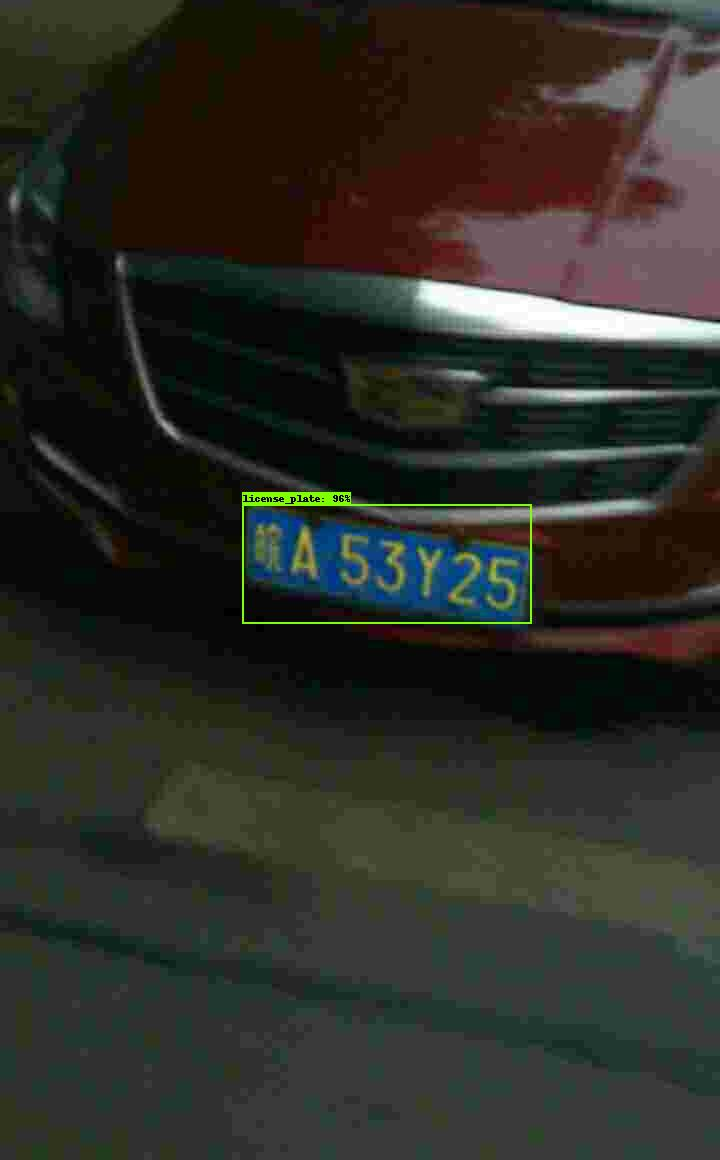

../../results/2.jpg


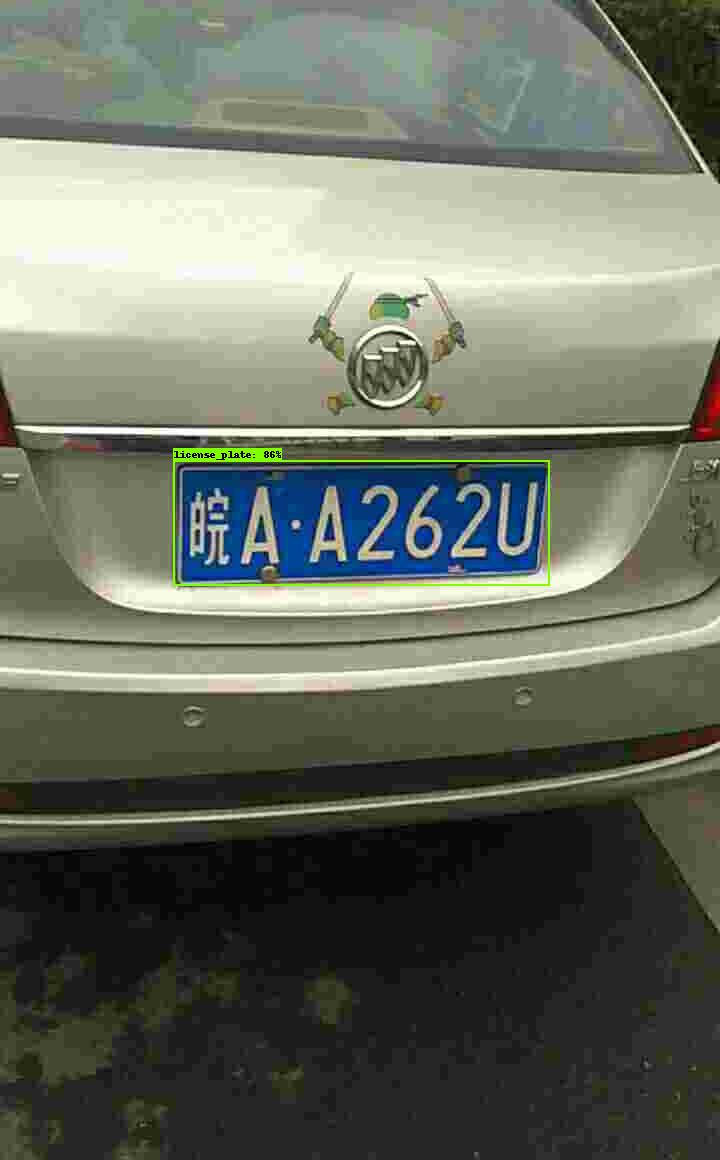

../../results/3.jpg


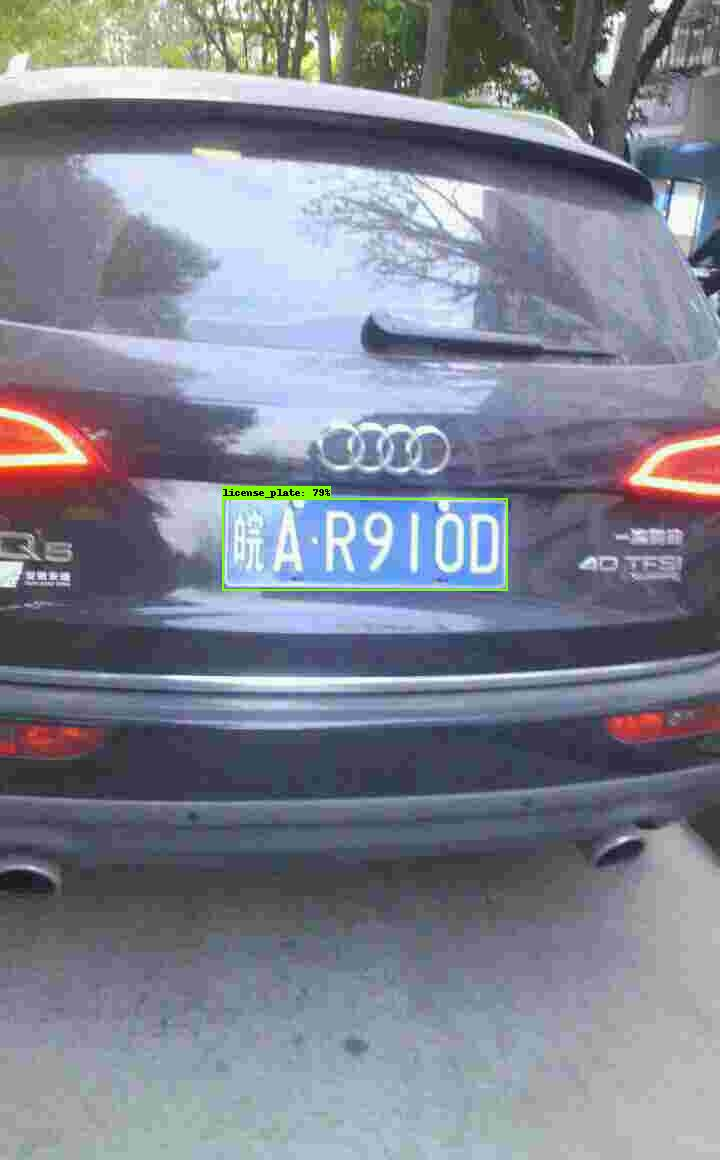

../../results/4.jpg


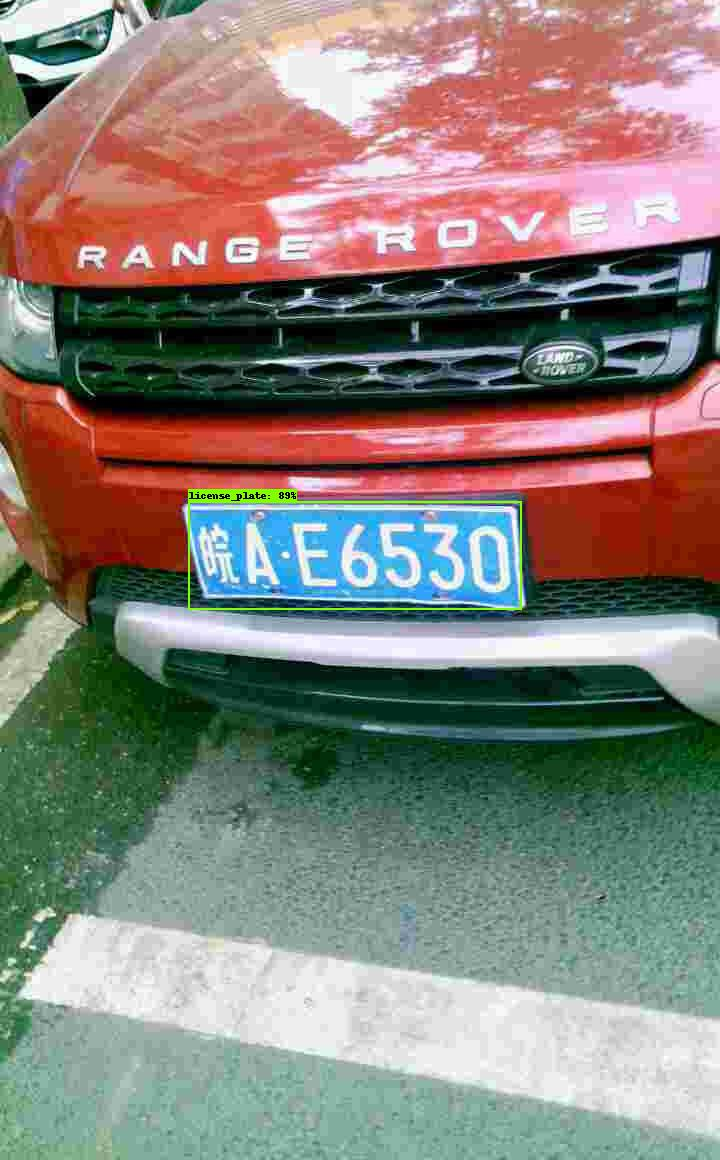

../../results/5.jpg


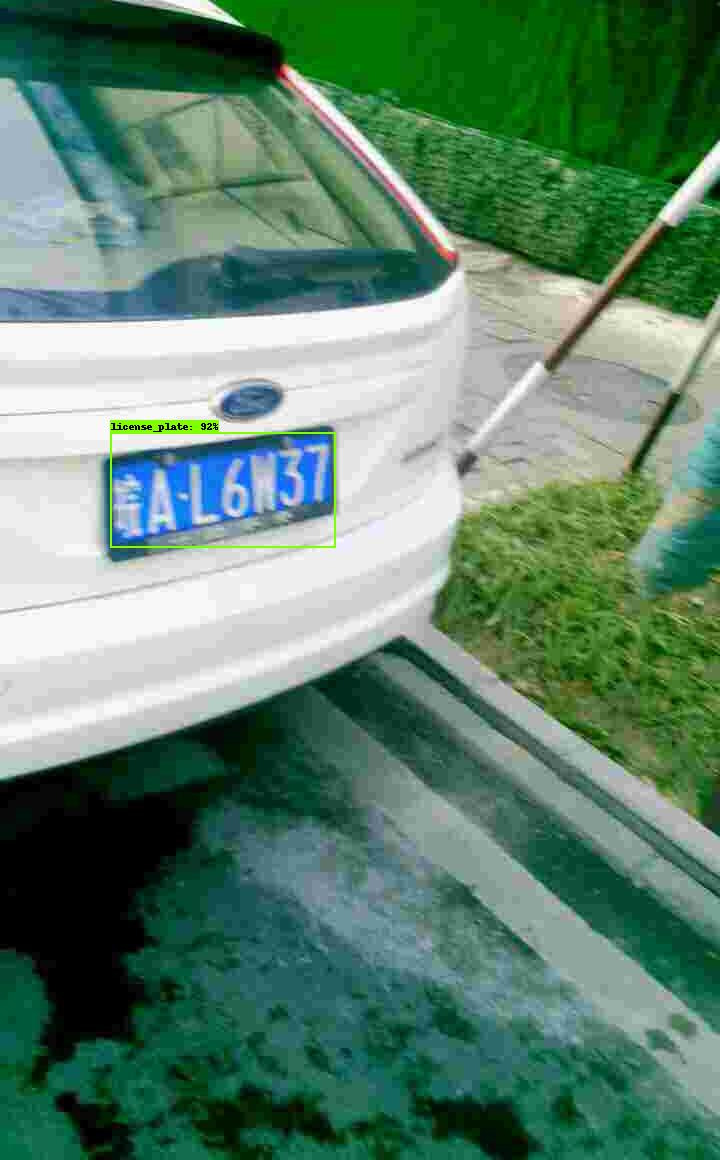

../../results/6.jpg


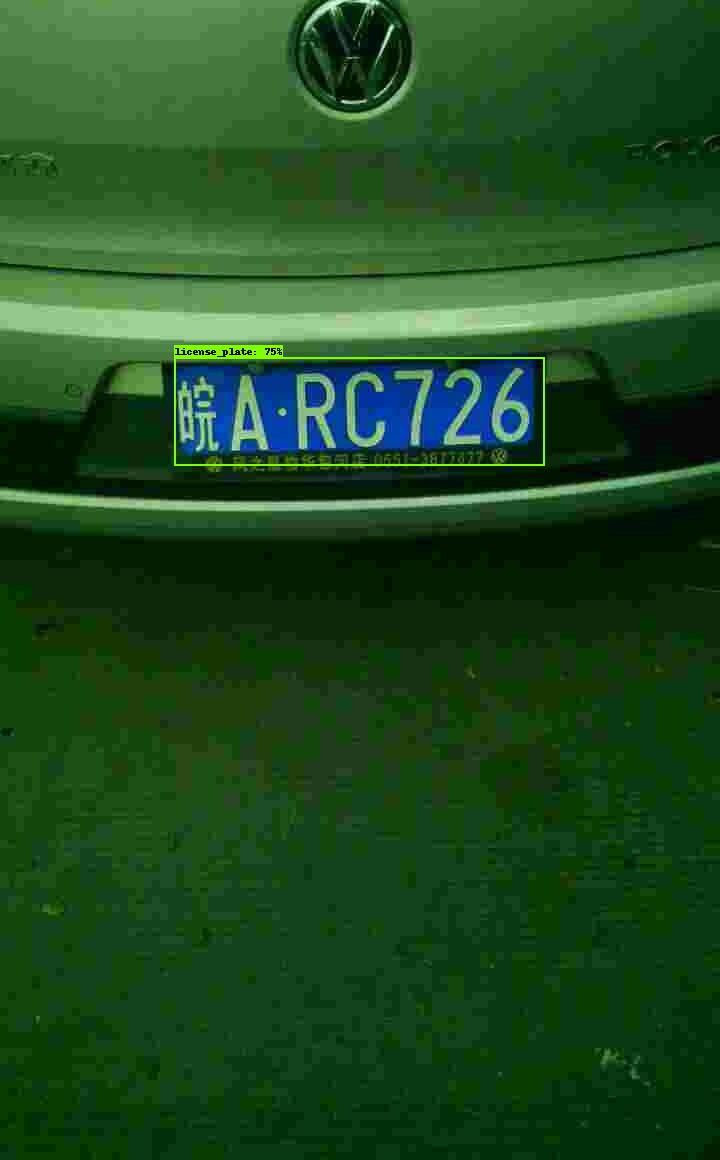

../../results/7.jpg


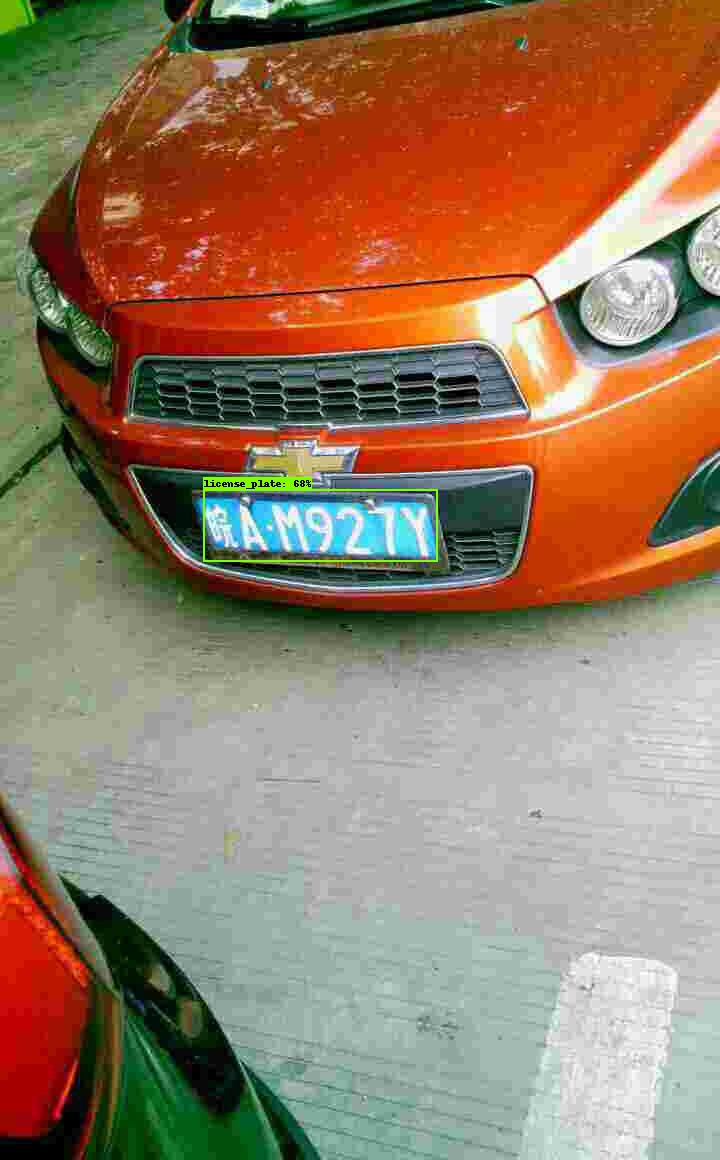

../../results/8.jpg


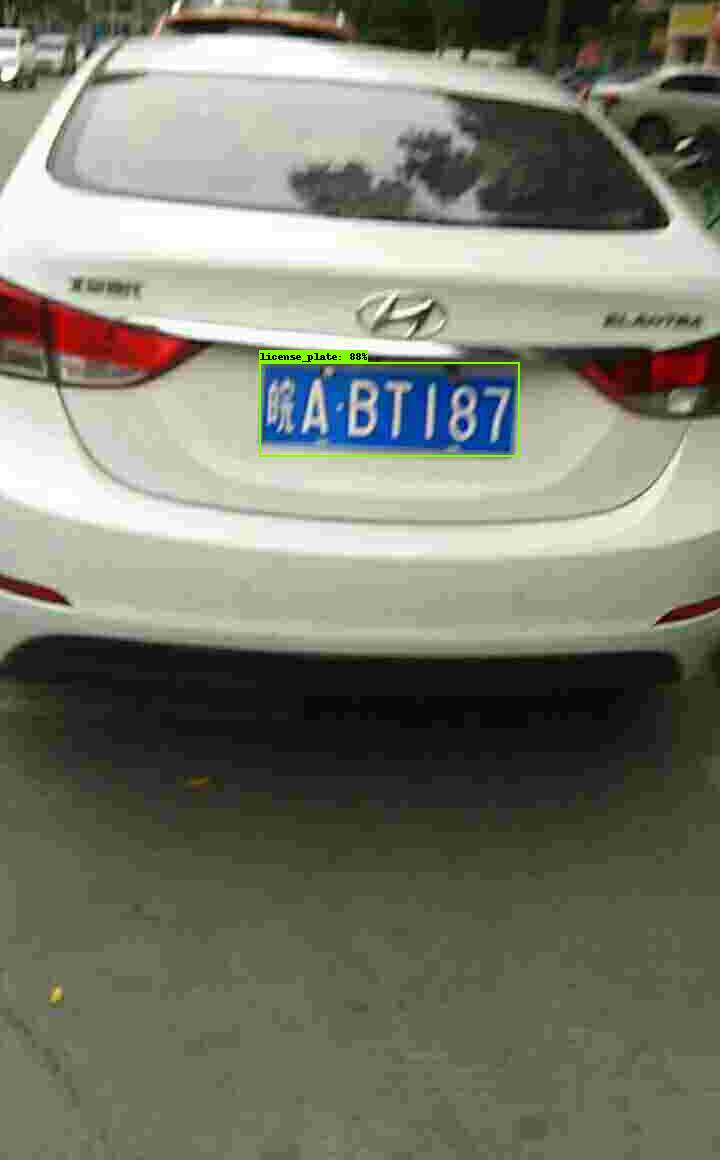

../../results/9.jpg


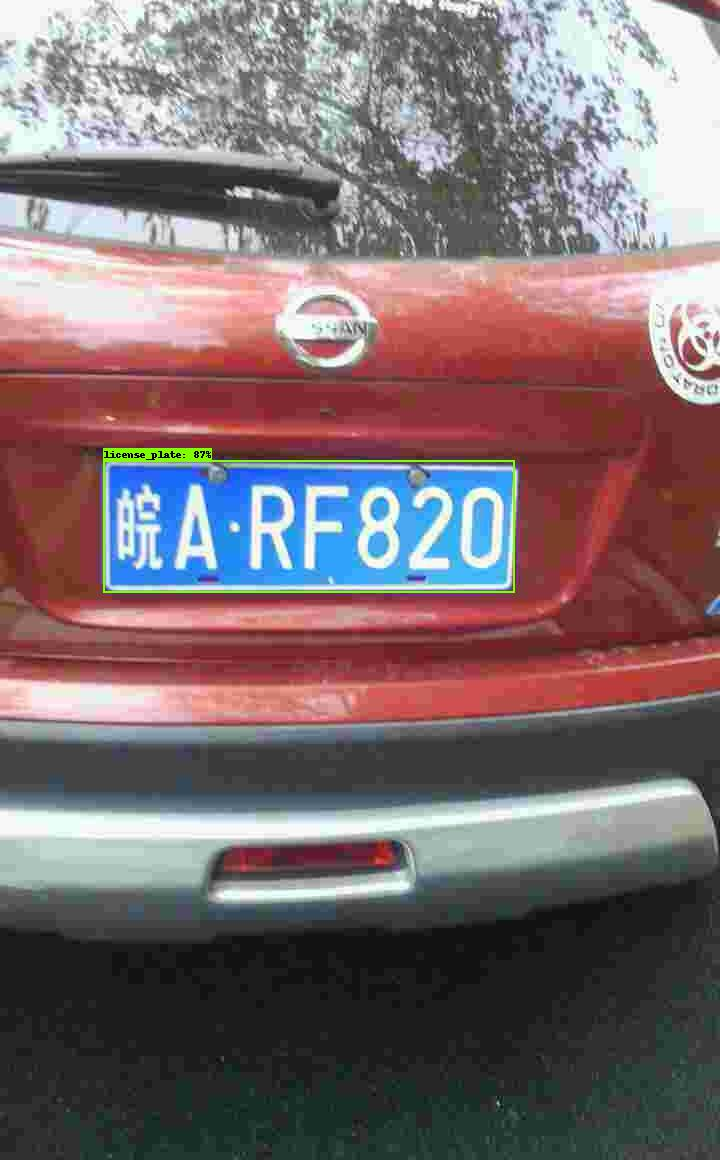

In [ ]:
from IPython.display import Image, display

MAX_SHOW_RESULTS = 10

for i in range(MAX_SHOW_RESULTS):
    fname = os.path.join(RESULT_DIR, "{}.jpg".format(i))
    if os.path.exists(fname):
        print(fname)
        display(Image(fname))